In [1]:
import importlib
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics

import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%config InlineBackend.figure_format = "retina"

# Load data

In [24]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# currents
j_du_ds = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/j_du_ds_3.npy", allow_pickle=True)[
    6
]  # 10 ns lag time
j_du_sb = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/j_du_sb_3.npy", allow_pickle=True)[
    6
]
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    0
]  # 0.1 ns lag time

Currents computed in `dga_220325.ipynb` 

In [7]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

# Committors

In [8]:
# color arrows from transparent to white depending on magnitude
rgb = 255 / 256
colors = [(rgb, rgb, rgb, c) for c in np.linspace(0.1, 1, 100)]
cmapwhite = mpl.colors.LinearSegmentedColormap.from_list("white", colors)

In [11]:
# states to do stopping
end = 4150115
dist = cv_arr[:end, 0]
rot = cv_arr[:end, 1]
sb1 = sb_arr[:end, 42]  # R226-D129
sb2 = sb_arr[:end, 47]  # R226-D186
sb3 = sb_arr[:end, 48]  # R229-D129
sb4 = sb_arr[:end, 53]  # R229-D186
sb5 = sb_arr[:end, 59]  # R232-D186

# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [12]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

In [13]:
from extq.stop import forward_stop

In [14]:
# compute E[\theta(x) S_tq_+(x)]
w_delay = [w[:-lag] for w in weights]
qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


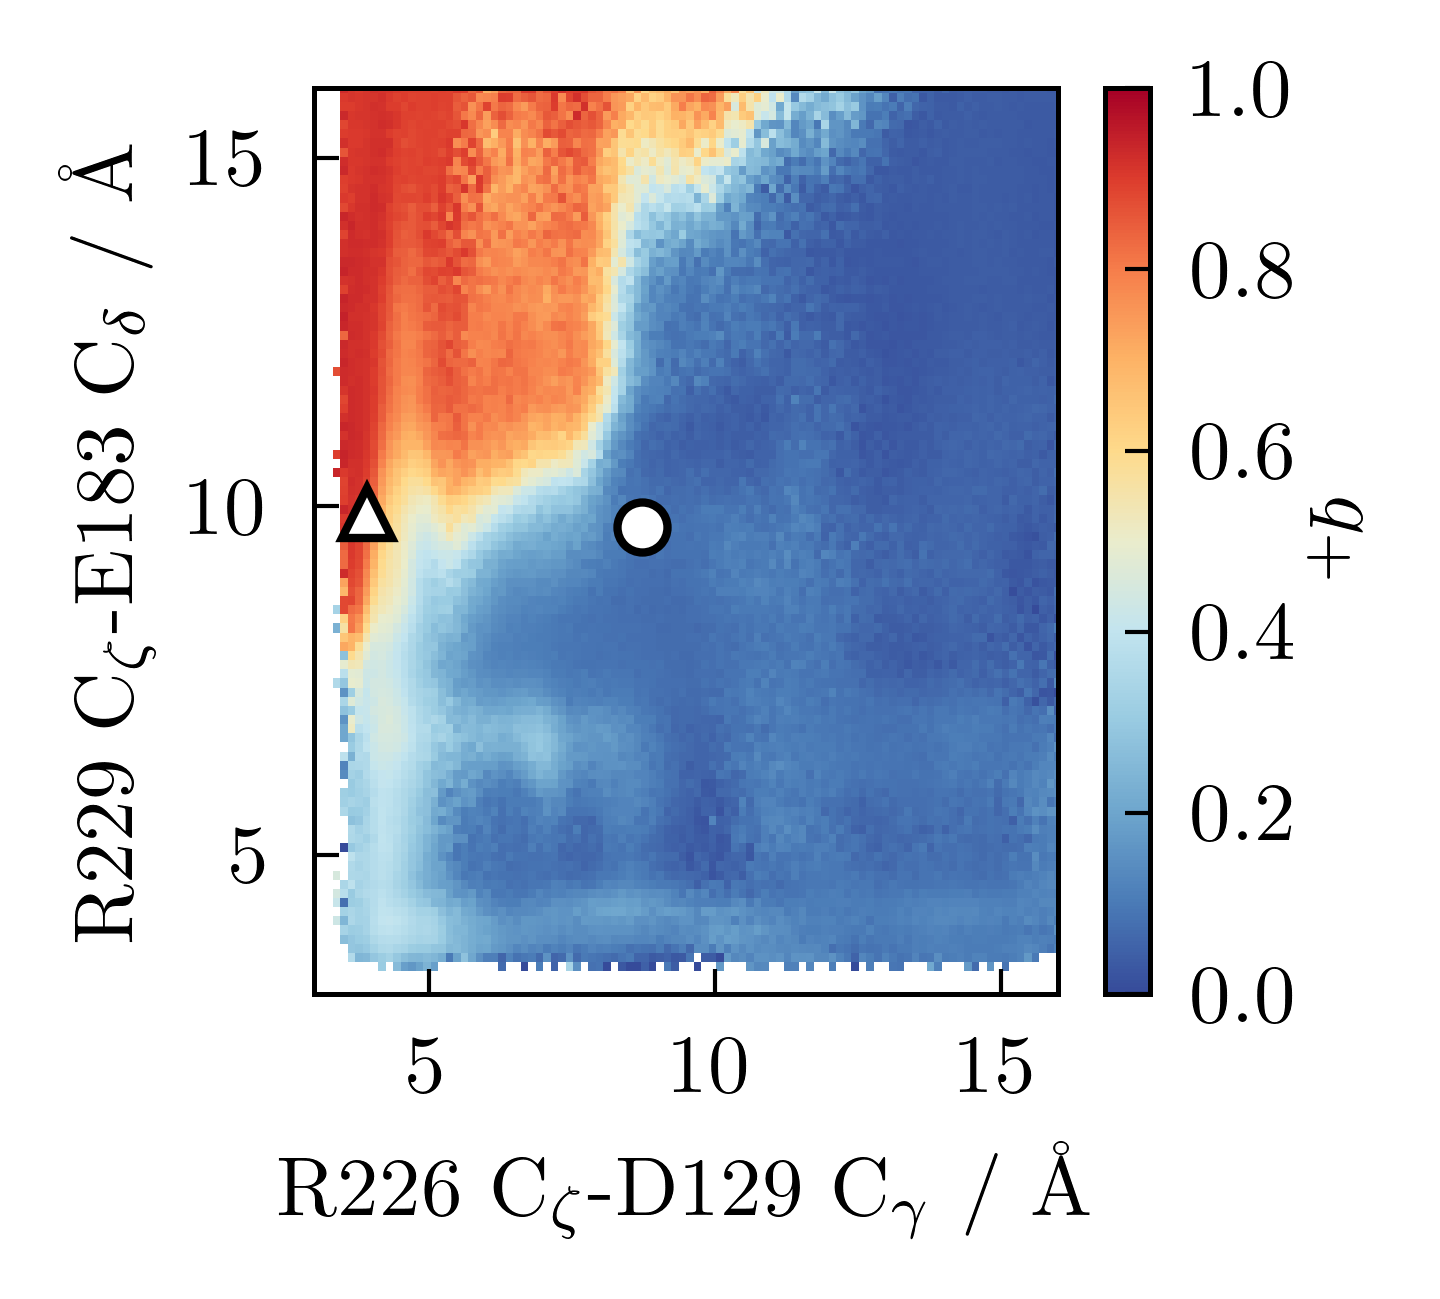

In [18]:
# R226-D129 and R229-E183
f = plt.figure(figsize=(2, 2), dpi=300)
ax = plt.gca()

r = [[3, 16], [3, 16]]
sb1, sb2 = 42, 52
sb1_trajs = [t[:-lag, sb1] * 10 for t in sb_trajs]
sb2_trajs = [t[:-lag, sb2] * 10 for t in sb_trajs]
xlim = np.linspace(*r[0], 101)
ylim = np.linspace(*r[1], 101)
q_dens = extq.projection.average2d(sb1_trajs, sb2_trajs, qp_delay, w_delay, xlim, ylim)
xc = np.linspace(*r[0], 100)
yc = np.linspace(*r[1], 100)
h = ax.pcolormesh(xc, yc, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
ax.set(
    xlabel=f"{sb_names[sb1]} / Å",
    ylabel=f"{sb_names[sb2]} / Å",
)

plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)
ax.set_xlim(r[0])
ax.set_ylim(r[1])

# f.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=3, labels=["_blank", '_', 'Down', 'Up', 'Up+'])
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1)
cb.set_label("$q_+$", rotation=-90, labelpad=10)

In [21]:
centroids = np.loadtxt("../../models/MD-clustering-center/all.txt")

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


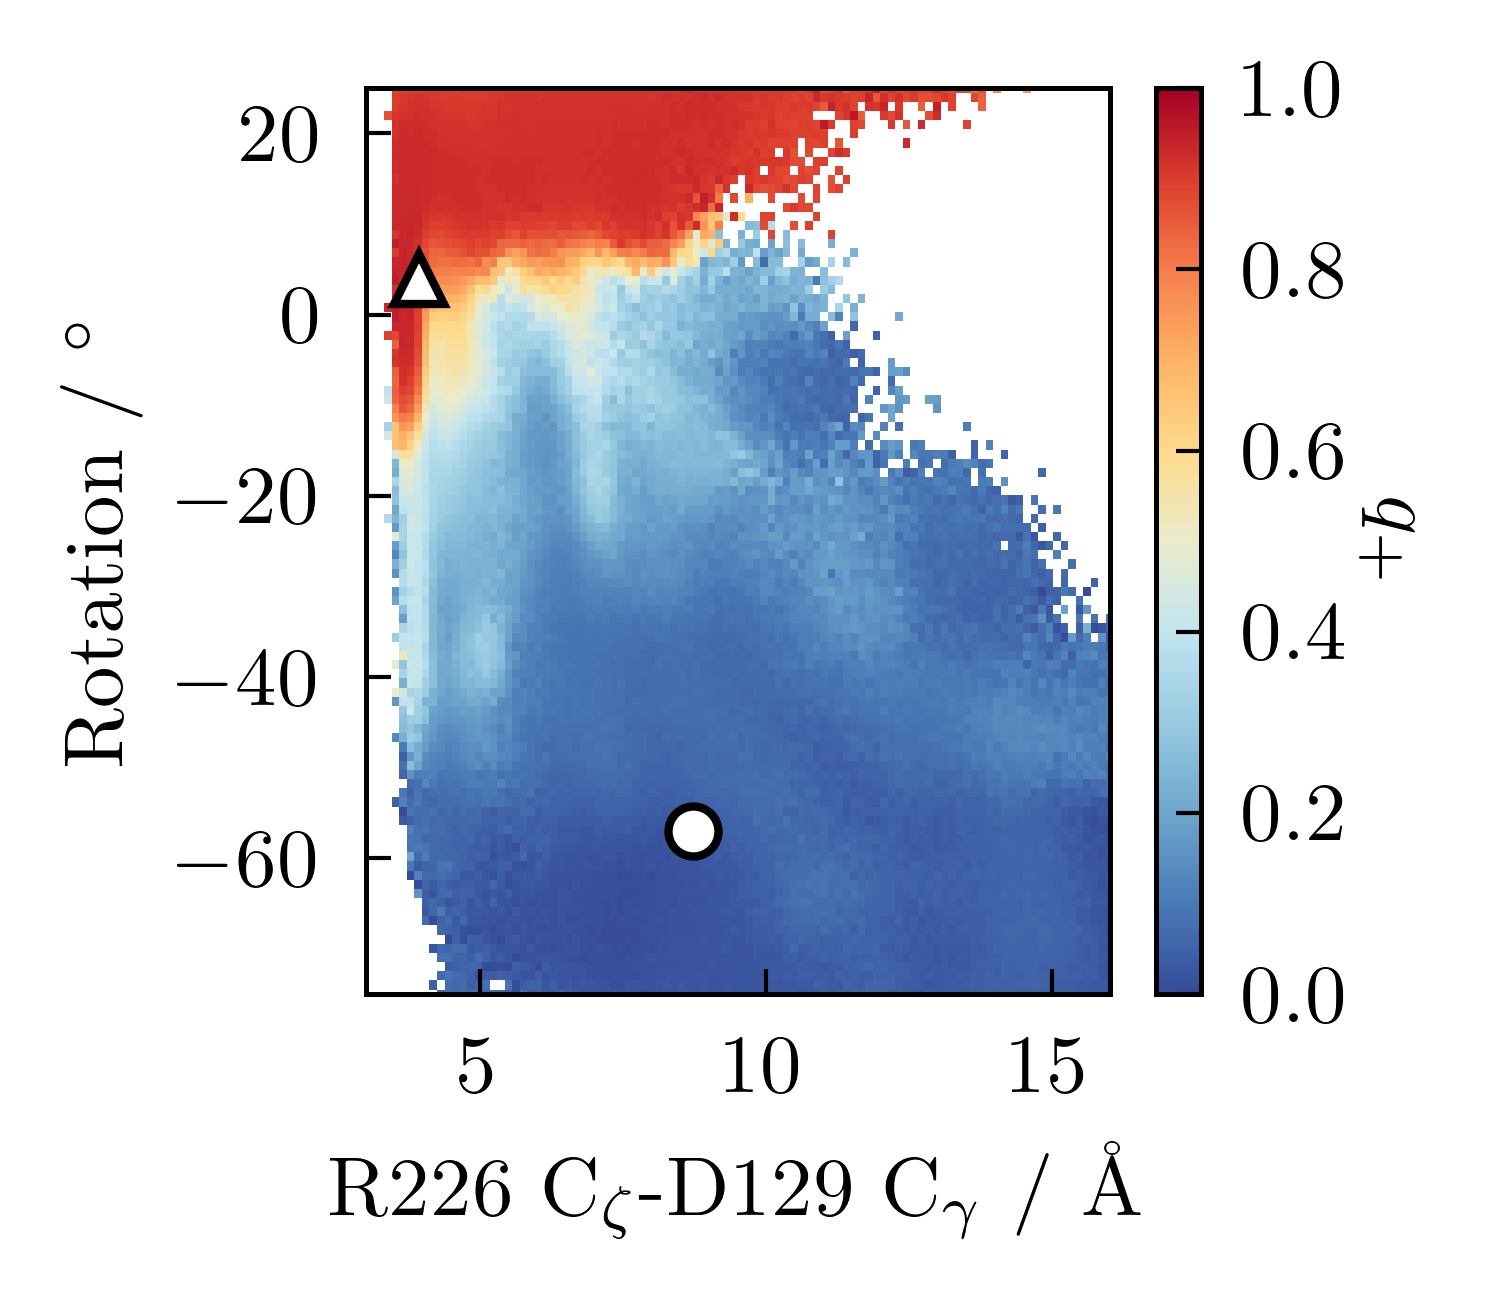

In [29]:
# rotation and R226-D129
f = plt.figure(figsize=(2, 2), dpi=300)
ax = plt.gca()

r = [[3, 16], [-75, 25]]
sb = 42
sb_lag = [t[:-lag, sb] * 10 for t in sb_trajs]
rot_trajs = [t[:-lag, 1] for t in cv_trajs]
xlim = np.linspace(*r[0], 101)
ylim = np.linspace(*r[1], 101)
q_dens = extq.projection.average2d(sb_lag, rot_trajs, qp_delay, w_delay, xlim, ylim)
xc = np.linspace(*r[0], 100)
yc = np.linspace(*r[1], 100)
h = ax.pcolormesh(xc, yc, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
ax.set(
    ylabel=f"Rotation / $^\circ$",
    xlabel=f"{sb_names[sb]} / Å",
)

# plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)
plotting.plot_single_model(ax, (sb_models[1, sb] * 10, centroids[1, 1]), 'd', ms=6)
plotting.plot_single_model(ax, (sb_models[2, sb] * 10, centroids[2, 1]), 'u', ms=6)
ax.set_xlim(r[0])
ax.set_ylim(r[1])

# f.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=3, labels=["_blank", '_', 'Down', 'Up', 'Up+'])
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1)
cb.set_label("$q_+$", rotation=-90, labelpad=10)

In [27]:
rf161 = list(np.load(f"{DATA_DIR}/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load(f"{DATA_DIR}/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

In [28]:
centroids_rf = np.load(f"{DATA_DIR}/models_centroids_rf161.npy")

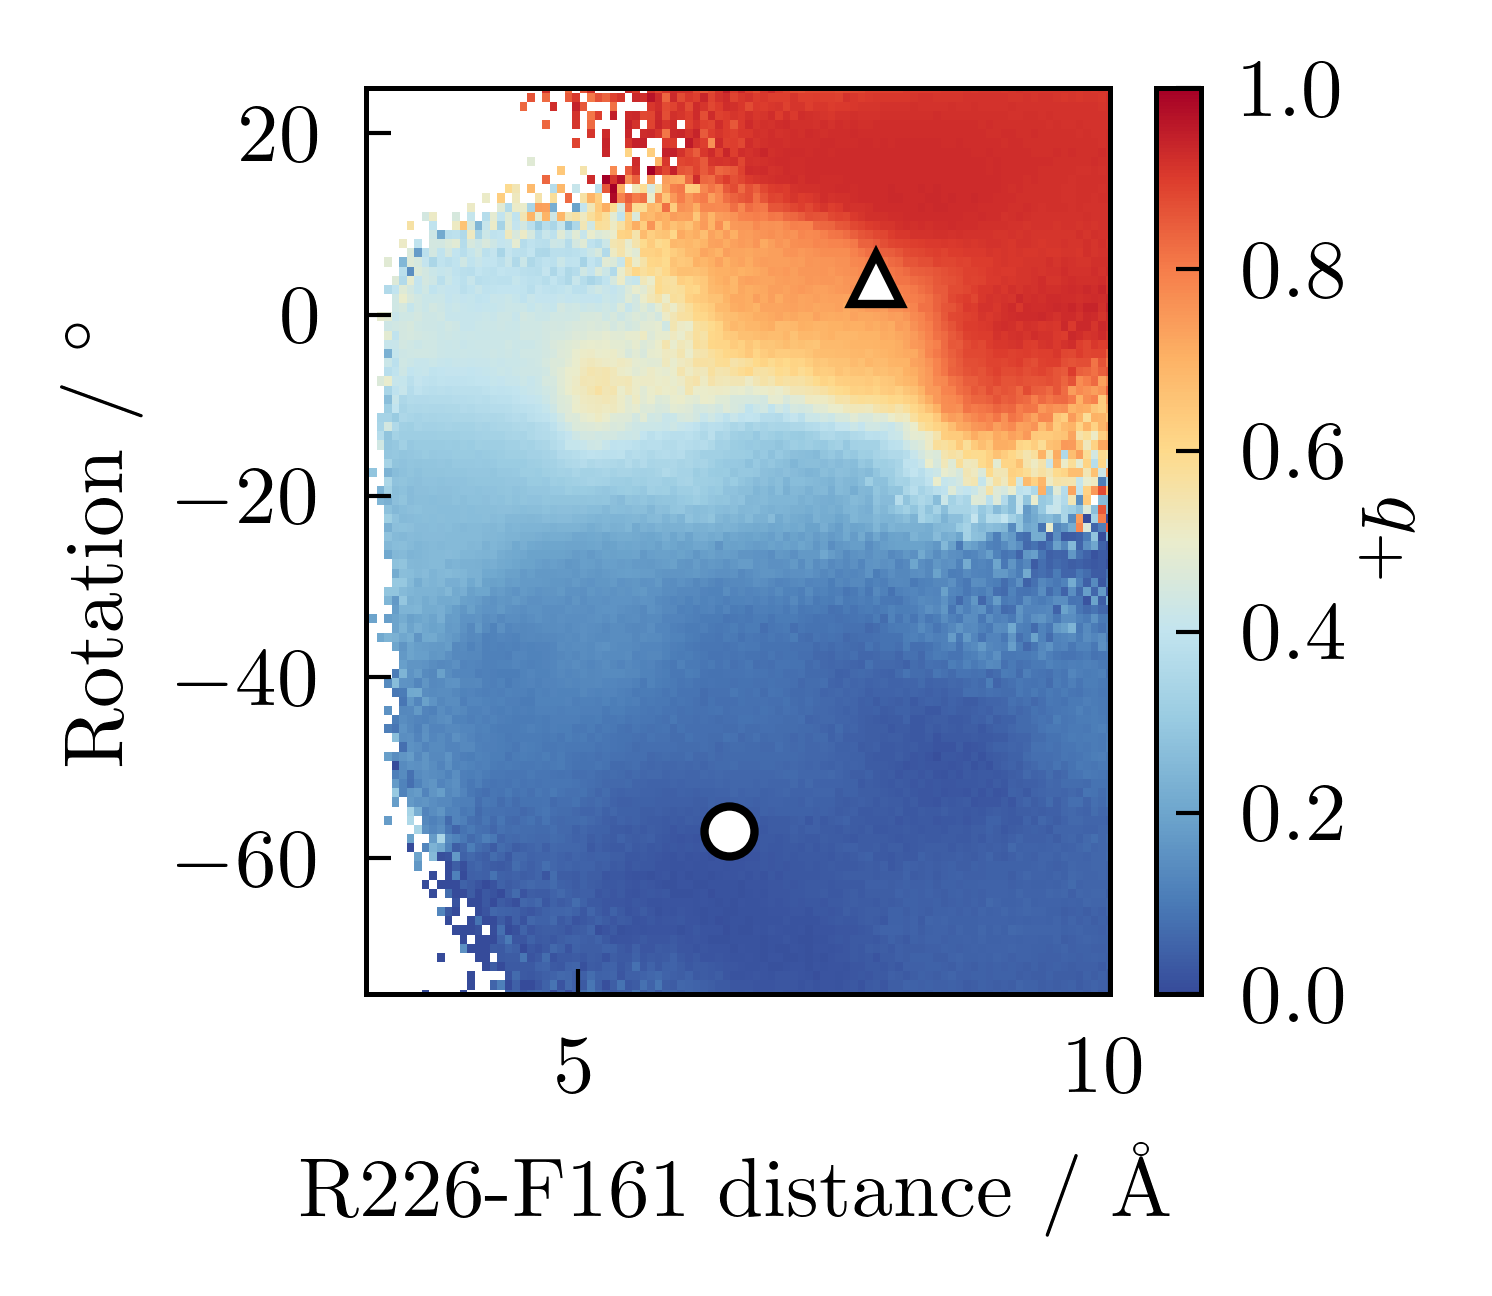

In [33]:
# rotation and R226-F161
f = plt.figure(figsize=(2, 2), dpi=300)
ax = plt.gca()

r = [[3, 10], [-75, 25]]
rf_trajs = [t[:-lag, 1] * 10 for t in rf161]
rot_trajs = [t[:-lag, 1] for t in cv_trajs]
xlim = np.linspace(*r[0], 101)
ylim = np.linspace(*r[1], 101)
q_dens = extq.projection.average2d(rf_trajs, rot_trajs, qp_delay, w_delay, xlim, ylim)
xc = np.linspace(*r[0], 100)
yc = np.linspace(*r[1], 100)
h = ax.pcolormesh(xc, yc, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
ax.set(
    ylabel=f"Rotation / $^\circ$",
    xlabel=f"R226-F161 distance / Å",
)

# plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)
plotting.plot_single_model(ax, (centroids_rf[1, 1] * 10, centroids[1, 1]), 'd', ms=6)
plotting.plot_single_model(ax, (centroids_rf[2, 1] * 10, centroids[2, 1]), 'u', ms=6)
ax.set_xlim(r[0])
ax.set_ylim(r[1])

# f.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=3, labels=["_blank", '_', 'Down', 'Up', 'Up+'])
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1)
cb.set_label("$q_+$", rotation=-90, labelpad=10)